# The Daubechies D4 Wavelet Tranform

##### All functions and variables declaration

In [36]:
from functions import *
import os
import random
import matplotlib.pyplot as plt
from time import time

#### Daubechies coefficients

In [37]:
################## 4 #################
ROOT2, ROOT3 = np.sqrt(2), np.sqrt(3) 

H_COEFFS4 = np.array([(1 + ROOT3) / (4 * ROOT2),(3 + ROOT3) / (4 * ROOT2), (3 - ROOT3) / (4 * ROOT2), (1 - ROOT3) / (4 * ROOT2)])
G_COEFFS4 = np.array([H_COEFFS4[3],-H_COEFFS4[2],H_COEFFS4[1],-H_COEFFS4[0]])


################## 8 #################
H_COEFFS8 = np.array([0.23037781, 0.71484657, 0.63088076, -0.02798376, -0.18703481, 0.03084138, 0.03288301, -0.01059740])
G_COEFFS8 = np.array([-0.01059740, -0.03288301, 0.03084138, 0.18703481, -0.02798376, -0.63088076, 0.71484657, -0.23037781])


##### Checking Orthonormality

In [38]:
h_coeffs, g_coeffs =  H_COEFFS8, G_COEFFS8
verificar_ortonormalidad(h_coeffs, g_coeffs)

The vectors are orthonormal, the dot product is: -8.673617379884035e-19 and the norm of each vector is (0.9999999931242683, 0.9999999931242683) respectively


## IMAGES EXAMPLES

In [39]:
datarute = r'C:\Users\Maqui\Documents\INTERNSHIP\CNN\UTKFace-crop_Renamed'

image_files = os.listdir(datarute)
random_index = random.randint(0, len(image_files) - 1)
random_image_filename = image_files[random_index]
random_image_path = os.path.join(datarute, random_image_filename)
print(random_image_path)

C:\Users\Maqui\Documents\INTERNSHIP\CNN\UTKFace-crop_Renamed\32_0_20170111181750357.jpg


In [40]:
# photo = 'images/foto_dataset1.jpg'
array_photo = jpg_to_pgm(random_image_path)

scale = 5
width = array_photo.shape[0]

daubechies_4 = function_daubechies_coeffs(array_photo, h_coeffs, g_coeffs)


result_img, normalized = daubechies4_wavelet_transform_2D(
    daubechies_4, array_photo, scale, width, h_coeffs, g_coeffs)


result_img1, normalized1, result_img2, normalized2, result_img3, normalized3 = get_details(scale, result_img, normalized)


reconstructed1 = inverse_daubechies4_wavelet_transform_2D(
    daubechies_4, result_img1, scale, width, h_coeffs, g_coeffs)

reconstructed2 = inverse_daubechies4_wavelet_transform_2D(
    daubechies_4, result_img2, scale, width, h_coeffs, g_coeffs)

reconstructed3 = inverse_daubechies4_wavelet_transform_2D(
    daubechies_4, result_img3, scale, width, h_coeffs, g_coeffs)

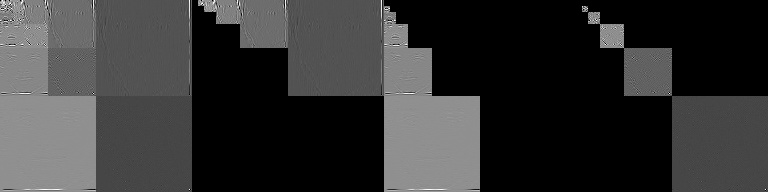

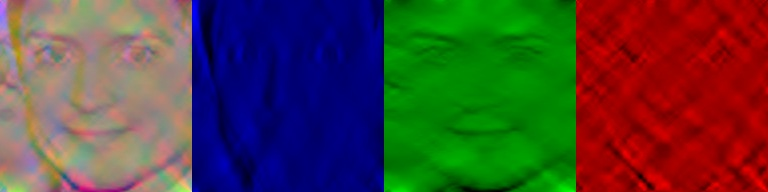

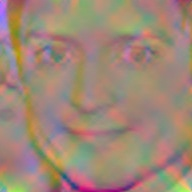

In [41]:
new_p(reconstructed1), new_p(reconstructed2), new_p(reconstructed3)

dH_redChannel = np.stack((reconstructed1,)*3, axis=-1)
dH_redChannel[:,:,1] = 0
dH_redChannel[:,:,2] = 0

dV_greenChannel = np.stack((reconstructed2,)*3, axis=-1)
dV_greenChannel[:,:,0] = 0
dV_greenChannel[:,:,2] = 0

dD_blueChannel = np.stack((reconstructed3,)*3, axis=-1)
dD_blueChannel[:,:,0] = 0
dD_blueChannel[:,:,1] = 0



# Add all the channels and show the final image
final_image = dH_redChannel + dV_greenChannel + dD_blueChannel

# show reconstructed image
imshow(np.concatenate((normalized, normalized1, normalized2, normalized3), axis=1))
       
# Show concatenated dH_redChannel, dV_greenChannel, dD_blueChannel
imshow(np.concatenate((final_image, dH_redChannel, dV_greenChannel, dD_blueChannel), axis=1))


imshow(final_image,512)